# Sequential Recommendation - Other Methods

* [Course Reviews on Coursera](https://www.kaggle.com/datasets/imuhammad/course-reviews-on-coursera)
* [Coursera Courses 2021](https://www.kaggle.com/datasets/khusheekapoor/coursera-courses-dataset-2021)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from coursemate.dataset import Dataset

In [2]:
from collections import defaultdict
from itertools import combinations
import math

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)

In [5]:
%load_ext autoreload
%autoreload 2

## Dataset class

In [6]:
dataset = Dataset('../data/Coursera_courses.csv', '../data/Coursera.csv', '../data/Coursera_reviews.csv')
dataset.set_interaction_counts(3, 50)
dataset.show_dataset_details()

Loading Coursera courses...
Loading Coursera reviews...
Segmenting out students with less than 3 or more than 50 reviews...
30719 students, 468 courses, 174219 reviews
Sparsity: 1.21%
Duplicates: 4.54%


## Getting the train-test split as a list of data points

In [7]:
dataset.set_train_test_split_by_user()
train_X, test_X, train_y, test_y = dataset.get_train_test_sequence_predictions()

Setting the train-test split by user...
Computing the training and test list of sequences...


131100it [00:13, 9728.62it/s] 
43119it [00:04, 9824.83it/s] 


## Constructing the association rules

### Version 1: Taking course I implies course J

In [11]:
train_X[1]

('By  B R s ',
 ('information-security-data', 'aws-fundamentals-going-cloud-native'))

In [12]:
train_y[1]

'python-basics'

In [13]:
assoc_rules = defaultdict(int)

for (_, prev_courses), next_course in zip(train_X, train_y):
    for p in prev_courses:
        assoc_rules[(p, next_course)] += 1

In [14]:
len(assoc_rules)

90472

### Version 2: Simple association rule mining

In [21]:
_, assoc_matrix = dataset.get_train_matrix_split()
assoc_matrix = np.clip(assoc_matrix, 0, 1)
assoc_matrix = assoc_matrix[assoc_matrix.sum(axis=1) > 0, :]
print(assoc_matrix.shape)

assoc_matrix

Computing the training and test rating matrix...


131100it [00:07, 17849.89it/s]

(23039, 468)


array([[1, 0, 1, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

<Axes: ylabel='Count'>

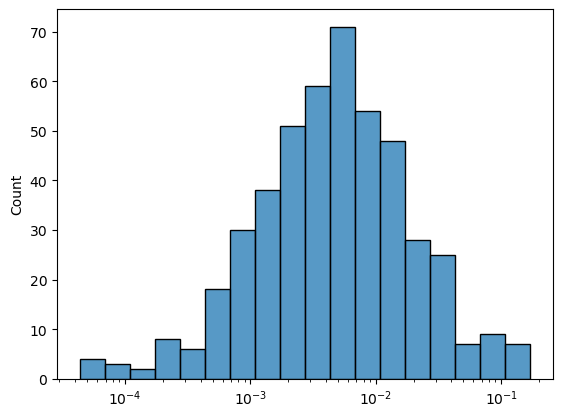

In [46]:
single_itemset_support = (assoc_matrix.sum(axis=0)) / (assoc_matrix.shape[0])
sns.histplot(single_itemset_support, log_scale=True)

In [48]:
(single_itemset_support > 0.005).sum()

227

In [56]:
len(np.where(single_itemset_support > 0.005)[0])

227

In [73]:
# Implement the Apriori algorithm to find frequent itemsets
def apriori_frequent_itemsets(data, min_support=0.005):
    num_transactions, num_items = data.shape
    frequent_itemsets = []

    # 1-itemsets
    single_itemset_support = (data.sum(axis=0)) / (data.shape[0])
    freq_1_itemsets = np.where(single_itemset_support > min_support)[0]
    frequent_itemsets = []

    k = 2
    found_new_itemset = True
    while found_new_itemset and k < num_items:
        found_new_itemset = False
        candidates = list(combinations(freq_1_itemsets, k))     # simplification: generates all combinations of size k
        print(f"{len(candidates)} candidates")
        for candidate in candidates:
            candidate_df = data[:, list(candidate)]
            support = (candidate_df.sum(axis=1) == k).mean()    # sum of row values: 1 if transaction contains item, 0 otherwise
            if support >= min_support:
                # print('Itemset', list(candidate), 'Support =', support)
                frequent_itemsets.append(list(candidate))
                found_new_itemset = True
        k += 1

    print(f"k: {k}")

    return frequent_itemsets

In [75]:
frequent_sets = apriori_frequent_itemsets(assoc_matrix, 0.01)
print(f"Number of frequent itemsets:\n{len(frequent_sets)}")

8911 candidates
392084 candidates
12840751 candidates


KeyboardInterrupt: 

This is taking a long-ass time

### Version 3: Using only the predetermined sequences

In [8]:
# get course sequences
full_seqs = {}

for (name, prevs_c), next_c in zip(train_X, train_y):
    full_seqs[name] = (*prevs_c, next_c)

In [9]:
full_seqs_ndx = {}

for n, cs in full_seqs.items():
    full_seqs_ndx[n] = tuple(dataset.course_set.index.get_loc(c) for c in cs)

In [10]:
full_seqs['By  C S V ']

('neural-networks-deep-learning',
 'machine-learning-projects',
 'ai-for-everyone',
 'introduction-tensorflow')

In [11]:
full_seqs_ndx['By  C S V ']

(9, 54, 6, 23)

In [12]:
def generate_subsequences(sequence_dict, k):
    subseq_counts = defaultdict(int)
    for _, seq in tqdm(sequence_dict.items()):
        for comb in combinations(seq, k):
            subseq_counts[comb] += 1

    return subseq_counts

In [13]:
seq1 = generate_subsequences(full_seqs_ndx, 1)
seq2 = generate_subsequences(full_seqs_ndx, 2)
seq3 = generate_subsequences(full_seqs_ndx, 3)

print(f"1-subsequences: {len(seq1)}")
print(f"2-subsequences: {len(seq2)}")
print(f"3-subsequences: {len(seq3)}")

100%|███████████████████████████████████████████████████████████████████████████| 23039/23039 [00:02<00:00, 9108.84it/s]

1-subsequences: 468
2-subsequences: 90472
3-subsequences: 1835231


In [14]:
df_seq1 = pd.DataFrame(seq1.items(), columns=['subsequence', 'count'])
df_seq2 = pd.DataFrame(seq2.items(), columns=['subsequence', 'count'])
df_seq3 = pd.DataFrame(seq3.items(), columns=['subsequence', 'count'])

df_seq = pd.concat([df_seq1, df_seq2, df_seq3])
df_seq_dict = {**seq1, **seq2, **seq3}

print(df_seq.shape)
df_seq.head()

(1926171, 2)


,subsequence,count
0,"(346,)",94
1,"(100,)",576
2,"(77,)",655
3,"(56,)",353
4,"(20,)",4055


<Axes: xlabel='support', ylabel='Count'>

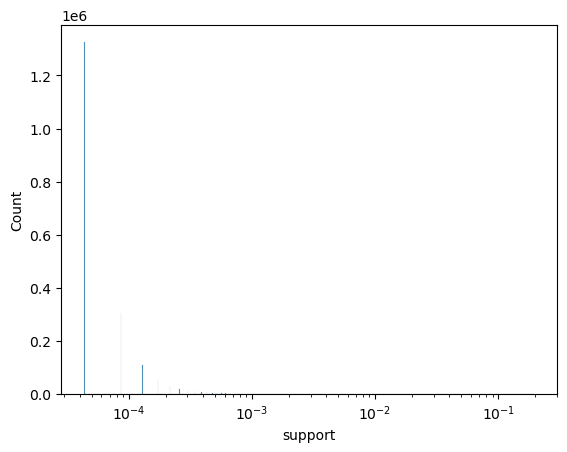

In [15]:
user_count = len(full_seqs_ndx)

df_seq['support'] = df_seq['count'] / user_count
sns.histplot(df_seq['support'], log_scale=True)

In [16]:
df_seq['count'].quantile([0.5, 0.75, 0.9, 0.99])

0.50     1.0
0.75     2.0
0.90     3.0
0.99    16.0
Name: count, dtype: float64

**Getting a frequent subsequence subset**

In [17]:
df_frequent_subseq = df_seq[(df_seq['count'] > 16) & (df_seq['subsequence'].apply(len) > 1)].copy()
df_frequent_subseq.shape

(18770, 3)

In [18]:
# constructing antecedents and consequents

df_frequent_subseq['antecedent'] = df_frequent_subseq['subsequence'].apply(lambda x: x[:-1])
df_frequent_subseq['consequent'] = df_frequent_subseq['subsequence'].apply(lambda x: (x[-1],))
df_frequent_subseq['antecedent_count'] = df_frequent_subseq['antecedent'].apply(lambda x: df_seq_dict[x] if x in df_seq_dict else 0)
df_frequent_subseq['consequent_count'] = df_frequent_subseq['consequent'].apply(lambda x: df_seq_dict[x] if x in df_seq_dict else 0)

df_frequent_subseq['confidence'] = df_frequent_subseq['count'] / df_frequent_subseq['antecedent_count']
df_frequent_subseq['lift'] = df_frequent_subseq['confidence'] / (df_frequent_subseq['antecedent_count'] / len(full_seqs_ndx))

df_frequent_subseq.head(10)

,subsequence,count,support,antecedent,consequent,antecedent_count,consequent_count,confidence,lift
4,"(100, 56)",19,0.000825,"(100,)","(56,)",576,353,0.032986,1.319387
6,"(20, 9)",659,0.028604,"(20,)","(9,)",4055,4433,0.162515,0.923352
7,"(20, 26)",307,0.013325,"(20,)","(26,)",4055,2708,0.075709,0.430150
8,"(20, 54)",260,0.011285,"(20,)","(54,)",4055,2290,0.064118,0.364297
9,"(20, 23)",190,0.008247,"(20,)","(23,)",4055,1008,0.046856,0.266217
10,"(20, 58)",66,0.002865,"(20,)","(58,)",4055,410,0.016276,0.092475
11,"(20, 132)",53,0.002300,"(20,)","(132,)",4055,257,0.013070,0.074260
12,"(9, 26)",1728,0.075003,"(9,)","(26,)",4433,2708,0.389804,2.025872
13,"(9, 54)",1388,0.060246,"(9,)","(54,)",4433,2290,0.313106,1.627263
14,"(9, 23)",394,0.017101,"(9,)","(23,)",4433,1008,0.088879,0.461917


## Predicting the next course

In [19]:
def generate_antecedents(prev_courses: tuple):
    return set(combinations(prev_courses, 1)) | set(combinations(prev_courses, 2))

In [20]:
def sequential_recommendation_by_confidence(prev_courses: tuple):
    """
    Given a set of prev courses, find 1-antecedents and 2-antecedents, and find the options with highest confidence
    """
    prev_courses_ndx = tuple(dataset.course_set.index.get_loc(c) for c in prev_courses)
    antecedents = generate_antecedents(prev_courses_ndx)
    _candidate_set = df_frequent_subseq[df_frequent_subseq['antecedent'].isin(antecedents)][['consequent', 'confidence']] \
                        .sort_values(by='confidence', ascending=False) \
                        .drop_duplicates(subset=['consequent'])
    _results = _candidate_set.head(5)['consequent'].apply(lambda x: x[0]).values
    return tuple(dataset.course_set.index.values[i] for i in _results)


def sequential_recommendation_by_lift(prev_courses: tuple):
    """
    Given a set of prev courses, find 1-antecedents and 2-antecedents, and find the options with highest lift
    """
    prev_courses_ndx = tuple(dataset.course_set.index.get_loc(c) for c in prev_courses)
    antecedents = generate_antecedents(prev_courses_ndx)
    _candidate_set = df_frequent_subseq[df_frequent_subseq['antecedent'].isin(antecedents)][['consequent', 'lift']] \
                        .sort_values(by='lift', ascending=False) \
                        .drop_duplicates(subset=['consequent'])
    _results = _candidate_set.head(5)['consequent'].apply(lambda x: x[0]).values
    return tuple(dataset.course_set.index.values[i] for i in _results)

In [21]:
def calculate_hit_rate(X, y, recommender_func):
    hits = 0
    reqs = 0
    for (user, prev_courses), next_course in tqdm(zip(X, y), total=len(X)):
        reqs += 1
        if next_course in recommender_func(prev_courses):
            hits += 1
    return hits / reqs

**By confidence**

In [22]:
calculate_hit_rate(train_X, train_y, sequential_recommendation_by_confidence)

100%|██████████████████████████████████████████████████████████████████████████| 108061/108061 [09:27<00:00, 190.57it/s]


0.2731975458305957

**By lift**

In [23]:
calculate_hit_rate(train_X, train_y, sequential_recommendation_by_lift)

100%|██████████████████████████████████████████████████████████████████████████| 108061/108061 [08:46<00:00, 205.22it/s]


0.2630273641739388

## Changing the frequent subsequences cutoff

In [30]:
COURSE_TO_INDEX = {
    c: ndx
    for ndx, c in enumerate(dataset.course_set.index)
}

INDEX_TO_COURSE = {
    ndx: c
    for ndx, c in enumerate(dataset.course_set.index)
}

class AssociationMiningModel:
    def __init__(self, cutoff, sequence_data):
        self.cutoff = cutoff
        self.mine_associations(sequence_data)

    def mine_associations(self, sequence_data):
        _df = sequence_data[(sequence_data['count'] > self.cutoff) & (sequence_data['subsequence'].apply(len) > 1)].copy()

        _df['antecedent'] = _df['subsequence'].apply(lambda x: x[:-1])
        _df['consequent'] = _df['subsequence'].apply(lambda x: (x[-1],))
        _df['antecedent_count'] = _df['antecedent'].apply(lambda x: df_seq_dict[x] if x in df_seq_dict else 0)
        _df['consequent_count'] = _df['consequent'].apply(lambda x: df_seq_dict[x] if x in df_seq_dict else 0)
        
        _df['confidence'] = _df['count'] / _df['antecedent_count']
        _df['lift'] = _df['confidence'] / (_df['antecedent_count'] / user_count)

        self.frequent_subseqs = _df

    def recommend_by_confidence(self, prev_courses: tuple, k=5):
        prev_courses_ndx = tuple(COURSE_TO_INDEX[c] for c in prev_courses)
        antecedents = generate_antecedents(prev_courses_ndx)
        _candidate_set = self.frequent_subseqs[self.frequent_subseqs['antecedent'].isin(antecedents)][['consequent', 'confidence']] \
                            .sort_values(by='confidence', ascending=False) \
                            .drop_duplicates(subset=['consequent'])
        _results = _candidate_set.head(k)['consequent'].apply(lambda x: x[0]).values
        return tuple(INDEX_TO_COURSE[i] for i in _results)

    def recommend_by_lift(self, prev_courses: tuple, k=5):
        prev_courses_ndx = tuple(COURSE_TO_INDEX[c] for c in prev_courses)
        antecedents = generate_antecedents(prev_courses_ndx)
        _candidate_set = self.frequent_subseqs[self.frequent_subseqs['antecedent'].isin(antecedents)][['consequent', 'lift']] \
                            .sort_values(by='lift', ascending=False) \
                            .drop_duplicates(subset=['consequent'])
        _results = _candidate_set.head(k)['consequent'].apply(lambda x: x[0]).values
        return tuple(INDEX_TO_COURSE[i] for i in _results)

In [31]:
def hit_rate_given_cutoff(cutoff, train_X, train_y):
    model = AssociationMiningModel(cutoff, df_seq)
    return calculate_hit_rate(train_X, train_y, model.recommend_by_confidence)

In [32]:
hit_rate_given_cutoff(3, train_X, train_y)

100%|██████████████████████████████████████████████████████████████████████████| 108061/108061 [15:37<00:00, 115.23it/s]


0.29137246555186425

In [33]:
hit_rate_given_cutoff(10, train_X, train_y)

100%|██████████████████████████████████████████████████████████████████████████| 108061/108061 [05:46<00:00, 311.69it/s]


0.2769176668733401

## Using a different dataset, predict any of the next courses

In [34]:
train_X, test_X, train_y, test_y = dataset.get_train_test_next_course_predictions()

Computing the training and test list of sequences...


131100it [00:08, 16028.93it/s]
43119it [00:02, 17405.54it/s]


In [43]:
def calculate_precision(X, y, recommender_func):
    precs = 0
    reqs = 0
    for (user, prev_courses_dict), next_courses_dict in tqdm(zip(X, y), total=len(X)):
        reqs += 1
        prev_courses = set(prev_courses_dict.keys())
        next_courses = set(next_courses_dict.keys())
        pred_courses = set(recommender_func(prev_courses))
        precs += (len(pred_courses & next_courses) / max(len(pred_courses), 1))
    return precs / reqs

In [36]:
model = AssociationMiningModel(3, df_seq)

In [44]:
calculate_precision(train_X, train_y, model.recommend_by_confidence)

100%|██████████████████████████████████████████████████████████████████████████| 108061/108061 [17:39<00:00, 101.95it/s]


0.17503878981944412

In [45]:
calculate_precision(test_X, test_y, model.recommend_by_confidence)

100%|████████████████████████████████████████████████████████████████████████████| 35439/35439 [05:37<00:00, 104.97it/s]


0.15190044865822314

## Generating scores for each test user and course

In [7]:
dataset.set_train_test_split_by_user()

# For the sequential/KB recommender
train_Xseq, test_Xseq, train_yseq, test_yseq = dataset.get_train_test_next_course_predictions()

from coursemate.model import AssociationMiningModel

# support cutoff determined empirically, testing the 90th and 99th percentile
model = AssociationMiningModel(cutoff=3, course_set=dataset.course_set)
df_seq = model.get_sequences_data(train_Xseq, train_yseq)
model.fit(df_seq)

Setting the train-test split by user...
Computing the training and test list of sequences...


131100it [00:06, 19559.01it/s]
43119it [00:02, 18646.22it/s]
100%|██████████████████████████████████████████████████████████████████████████| 23039/23039 [00:01<00:00, 17969.13it/s]


1-subsequences: 468
2-subsequences: 90472
3-subsequences: 1835231
(1926171, 2)


In [10]:
test_Xseq[0]

('By  A O', ('python-network-data', 'python-databases'))

In [11]:
_dfs = []

for user, prev_courses in tqdm(test_Xseq):
    _dfs.append(model.generate_scores(user, prev_courses))

100%|██████████████████████████████████████████████████████████████████████████████| 7680/7680 [01:12<00:00, 105.36it/s]


In [12]:
df_seq_scores = pd.concat(_dfs)

df_seq_scores.head()

,user,course,confidence
137,By A O,python-databases,0.319735
138,By A O,matlab,0.026093
156,By A O,python-data-visualization,0.225951
157,By A O,r-programming,0.051452
158,By A O,data-scientists-tools,0.067622


In [13]:
df_seq_scores.shape

(2455862, 3)

<Axes: xlabel='confidence', ylabel='Count'>

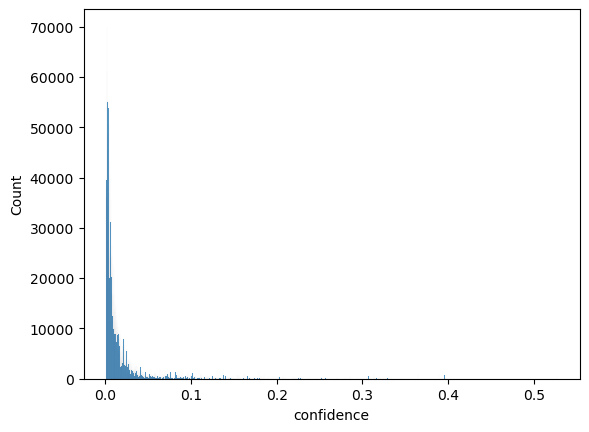

In [14]:
sns.histplot(df_seq_scores.confidence)

In [19]:
df_seq_scores.reset_index(drop=True).to_pickle('./sequential_rm_scores.pkl')